Đây là một thuật toán phân cụm thông minh, không cần chọn số cụm trước, và tự động phát hiện nhiễu (outliers) — cực kỳ hữu ích trong thực tế!

Mình sẽ trình bày theo đúng phong cách bạn yêu thích:

🔹 1. Nguyên lý hoạt động (không công thức nặng!)
🎯 Mục tiêu:
Nhóm các điểm gần nhau và dày đặc thành cụm.
Gán nhãn "nhiễu" cho các điểm cô lập, thưa thớt.
Không cần biết trước số cụm!
🧠 Ý tưởng chính — “Cụm = vùng dày đặc, còn lại là nhiễu”
DBSCAN dựa trên mật độ (density), không phải hình dạng hay số lượng.

Nó dùng 2 tham số chính:

eps (epsilon): bán kính lân cận.
min_samples: số điểm tối thiểu trong bán kính eps để được coi là "lõi" (core point).
🔍 Ba loại điểm:
Core point (điểm lõi):
→ Có ít nhất min_samples điểm trong bán kính eps.
Border point (điểm biên):
→ Không đủ điểm để là lõi, nhưng nằm trong vùng lân cận của điểm lõi.
Noise point (nhiễu):
→ Không phải lõi, cũng không gần lõi nào → bị gán là nhiễu.
💡 Quy trình:
Bắt đầu từ một điểm lõi → mở rộng cụm bằng cách kết nối tất cả điểm lõi lân cận.
Cứ thế, cụm phát triển theo mật độ, có thể hình dạng bất kỳ (tròn, trăng lưỡi liềm, chữ S...).
Các điểm không thuộc cụm nào → nhiễu.
✅ Ưu điểm:
Không cần chọn số cụm K.
Phát hiện nhiễu tự động.
Xử lý tốt cụm hình dạng phức tạp.
Ổn định với nhiễu.
❌ Hạn chế:
Khó chọn eps và min_samples (cần hiểu dữ liệu).
Không hiệu quả khi mật độ cụm khác nhau nhiều.
Chậm với dữ liệu lớn (nếu không dùng cấu trúc dữ liệu tối ưu).
🔹 3. Khi nào dùng DBSCAN?
Dữ liệu có
cụm hình dạng phức tạp
(trăng, vòng tròn...)
Cụm có
mật độ rất khác nhau
(một cụm dày, một cụm thưa)
Bạn
không biết số cụm
Dữ liệu
rất lớn
(triệu điểm) → dùng
HDBSCAN
hoặc
approximate DBSCAN
Cần
phát hiện nhiễu/gian lận
(fraud detection)
Đặc trưng
chưa chuẩn hóa
→
bắt buộc chuẩn hóa trước!
Dữ liệu
không gian liên tục
(2D, 3D, embedding...)
Dữ liệu
phân loại thuần túy
(không có khoảng cách rõ ràng)

🎯 So sánh nhanh với K-Means:
Cần chọn K?
✅ Có
❌ Không
Phát hiện nhiễu?
❌ Không
✅ Có
Hình dạng cụm
Chỉ hình cầu
✅ Bất kỳ
Mật độ cụm
Giả định đều
✅ Xử lý mật độ khác nhau (trong giới hạn)
Tốc độ
⚡ Rất nhanh
🐢 Trung bình/chậm
Dễ dùng
✅ Rất dễ
⚠️ Cần tinh chỉnh
eps
,
min_samples

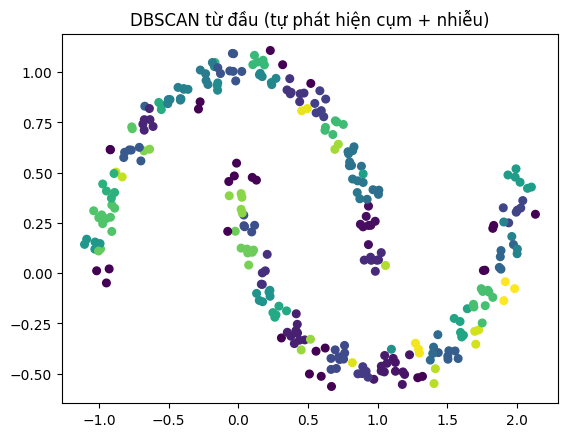

✅ DBSCAN tự code đã chạy!
🔍 Sklearn tìm được 7 cụm và 13 điểm nhiễu.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

class SimpleDBSCAN:
    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples

    def _euclidean_distance(self, a, b):
        return np.sqrt(np.sum((a - b) ** 2))

    def _region_query(self, X, point_idx):
        """Tìm tất cả điểm trong bán kính eps của point_idx"""
        neighbors = []
        for i in range(len(X)):
            if self._euclidean_distance(X[point_idx], X[i]) <= self.eps:
                neighbors.append(i)
        return neighbors

    def _expand_cluster(self, X, labels, point_idx, neighbors, cluster_id):
        """Mở rộng cụm từ một điểm lõi"""
        labels[point_idx] = cluster_id
        i = 0
        while i < len(neighbors):
            neighbor_idx = neighbors[i]
            if labels[neighbor_idx] == -1:  # chưa gán
                labels[neighbor_idx] = cluster_id
                # Nếu là điểm lõi, mở rộng tiếp
                neighbor_neighbors = self._region_query(X, neighbor_idx)
                if len(neighbor_neighbors) >= self.min_samples:
                    neighbors.extend(neighbor_neighbors)
            elif labels[neighbor_idx] == 0:  # đang là nhiễu, nhưng thuộc cụm
                labels[neighbor_idx] = cluster_id
            i += 1

    def fit(self, X):
        n_points = len(X)
        labels = np.zeros(n_points)  # 0 = chưa xử lý, -1 = nhiễu
        cluster_id = 0

        for i in range(n_points):
            if labels[i] != 0:  # đã xử lý
                continue

            neighbors = self._region_query(X, i)
            if len(neighbors) < self.min_samples:
                labels[i] = -1  # đánh dấu nhiễu
            else:
                cluster_id += 1
                self._expand_cluster(X, labels, i, neighbors, cluster_id)

        self.labels = labels

    def fit_predict(self, X):
        self.fit(X)
        return self.labels

# --- Thử nghiệm với dữ liệu hình trăng lưỡi liềm ---
from sklearn.datasets import make_moons, make_circles

# Tạo dữ liệu phi tuyến (K-Means sẽ thất bại!)
X, _ = make_moons(n_samples=300, noise=0.05, random_state=42)
# Hoặc thử: X, _ = make_circles(n_samples=300, noise=0.05, factor=0.5, random_state=42)

# Huấn luyện DBSCAN tự code
dbscan = SimpleDBSCAN(eps=0.1, min_samples=5)
labels = dbscan.fit_predict(X)

# Vẽ kết quả
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30)
plt.title("DBSCAN từ đầu (tự phát hiện cụm + nhiễu)")
plt.show()

# So sánh với sklearn
from sklearn.cluster import DBSCAN as SklearnDBSCAN
sk_dbscan = SklearnDBSCAN(eps=0.1, min_samples=5)
sk_labels = sk_dbscan.fit_predict(X)

print("✅ DBSCAN tự code đã chạy!")
print(f"🔍 Sklearn tìm được {len(set(sk_labels)) - (1 if -1 in sk_labels else 0)} cụm và {np.sum(sk_labels == -1)} điểm nhiễu.")